# RHme2 eSCAlate challenge

This is an example of using Jlsca to analyze the trace set from the "hard" SCA challenge of RHme2 embedded CTF (http://rhme.riscure.com/home).

The challenge features a somewhat protected SW AES-128 implementation on an 8-bit AVR microcontroller. You can send plaintext blocks to the device and receive blocks of ciphertext. The goal is to recover the encryption key.

Power traces were acquired using ChipWhisperer Lite and accompanying software (https://wiki.newae.com/Main_Page). The trigger was at the end of the cipher execution. 24400 samples preceding the trigger were acquired at 22 MS/s sampling rate. The 305 MB tarball with traces is available at https://drive.google.com/open?id=0B2slHLSL3nXaOHdhTXpMMHZkNjQ, shasum `d6ca416b5e9b6009710bae5df51f6217333667d0`. Uncompress it next to this notebook.

In [1]:
# load the tools
using Jlsca.Sca
using Jlsca.Trs
using Jlsca.Align
using Jlsca.Aes
using PyCall
using PyPlot.plot,PyPlot.figure

@pyimport numpy

## Convert traces from ChipWhisperer capture to Trs format

Needed just once to create the trs file. The rest of the code uses the trs file.

In [2]:
# prefix identifying the capture, bulky as it is
# (so far have been lazy to automate based on ChipWhisperer config file)
prefix = "rhme2-escalate-longer-traces/2017.01.27-17.45.58_"

# read the data from chipwhisperer capture
samples = numpy.load("$(prefix)traces.npy");
input = numpy.load("$(prefix)textin.npy");
output = numpy.load("$(prefix)textout.npy");

# get the parameters
numberOfTraces = size(input)[1] # because it happens that CW software saves more traces then inputs o_O
numberOfSamples = size(samples)[2]
dataSpace = size(input)[2] + size(output)[2]
sampleType = Float32;

# create and save the trs
trs = InspectorTrace("rhme2-escalate-longer-traces.trs", dataSpace, sampleType, numberOfSamples)
for t in 1:numberOfTraces
  trs[t] = (vcat(input[t,:],output[t,:]), map(Float32, samples[t,:]))
end
close(trs)

Creating Inspector trs file rhme2-escalate-longer-traces.trs
#samples: 24400
#data:    32
type:     Float32
Wrote 10000 traces in rhme2-escalate-longer-traces.trs


## Explore the traces
To see if there are any interesting patterngs and how well they are aligned.

In [3]:
# load the traceset
trs = InspectorTrace("rhme2-escalate-longer-traces.trs");

Opened rhme2-escalate-longer-traces.trs, #traces 10000, #samples 24400 (Float32), #data 32


In [4]:
# read 10 traces
((data,samples),eof) = readTraces(trs, 1:10);

Plot 3 traces

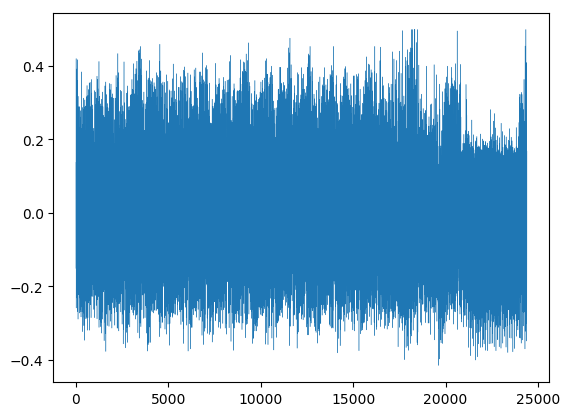

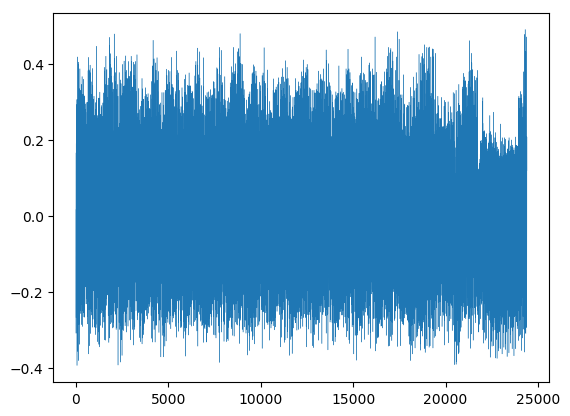

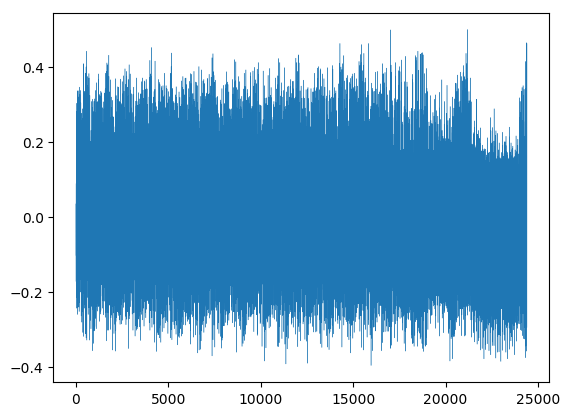

In [5]:
for i in 1:3; figure(); plot(samples[i,:],linewidth=.3); end

Zoom in at the end, plot a few (now overlayed), observe the alignment is not very good

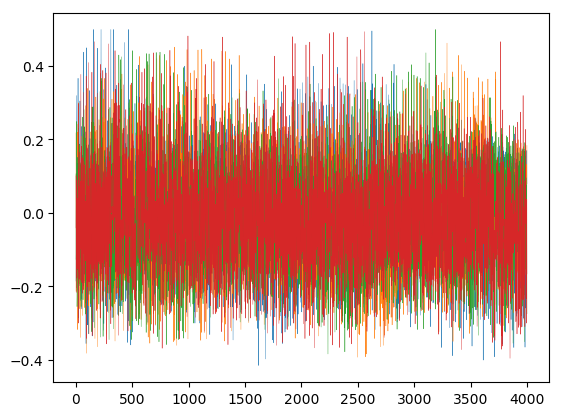

In [6]:
zoomstart = 18000
zoomend = 22000

plot(samples[1:4,zoomstart:zoomend]', linewidth=.3);

# Find good alignment
Playing with the start and end of the reference pattern, and keeping the rejection threshold at 0.

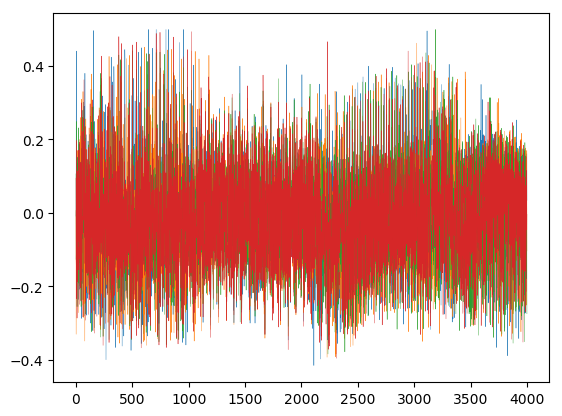

Processing traces .. 100%|██████████████████████████████| Time: 0:00:03


In [7]:
reset(trs)

maxShift = 20000
referencestart = zoomstart + 1000
referenceend = referencestart + 1500
reference = trs[3][2][referencestart:referenceend]
corvalMin = 0.0
alignstate = CorrelationAlignFFT(reference, referencestart, maxShift)

addSamplePass(trs, x -> ((shift,corval) = correlationAlign(x, alignstate); corval > corvalMin ? circshift(x, shift) : Vector{eltype(x)}(0)))

((data,samples),eof) = readTraces(trs, 1:4)

popSamplePass(trs)

plot(samples[1:4,18000:22000]', linewidth=.3);

In [8]:
close(trs)

## CPA attack with alignment

In [2]:
trs = InspectorTrace("rhme2-escalate-longer-traces.trs")

params = DpaAttack(AesSboxAttack(), CPA())
params.dataOffset = 17
params.attack.direction = BACKWARD
#params.analysis.leakages = [Bit(i) for i in 0:7]  # this is for all-bit abs-sum CPA
params.analysis.leakages = [HW()]

numberOfTraces = length(trs);

Opened rhme2-escalate-longer-traces.trs, #traces 10000, #samples 24400 (Float32), #data 32


Prepare the alignment pass, bump the corvalMin to throw away stuff that is poorly aligned

We're also throwing away everything outside our window of interest before it goes into the attack, after alignment

In [3]:
popSamplePass(trs)
popSamplePass(trs)

zoomstart = 18000
zoomend = 22000
maxShift = 20000
referencestart = zoomstart + 1000
referenceend = referencestart + 1500
reference = trs[3][2][referencestart:referenceend]
corvalMin = 0.4
alignstate = CorrelationAlignFFT(reference, referencestart, maxShift)

addSamplePass(trs, x -> ((shift,corval) = correlationAlign(x, alignstate); corval > corvalMin ? circshift(x, shift) : Vector{eltype(x)}(0)));
addSamplePass(trs, x -> x[zoomstart-1000:zoomend]);

Run with conditional averaging

In [4]:
reset(trs) # note, this resets the conditional averager, it doesn't pop the sample passes

setPostProcessor(trs, CondAvg())  
rankData = sca(trs, params, 1, numberOfTraces)
key = getKey(params,rankData)



Jlsca running in Julia version: 0.6.1, 1 processes/1 workers/2 threads per worker

DPA parameters
attack:       AES Sbox
mode:         CIPHER
key length:   KL128
direction:    BACKWARD
analysis:     CPA
leakages:     HW
maximization: abs global max
data at:      17

phase: 1 / 1, #targets 16

Running processor "Cond avg" on trace range 1:1:10000, 2 data passes, 2 sample passes


Processing traces 1:10000.. 100%|███████████████████████| Time: 0:00:15



Averaged 10000 input traces into 16 averages, UInt8 data type, Float64 sample type
CPA on samples shape (256, 5001) (range 1:5001) and data shape (256,)
Results @ 256 rows, 5001 cols (10000 rows, 5001 cols, consumed)
target: 1, phase: 1, "Inverse sbox out"
rank:   1, candidate: 0x42, peak: 0.366851 @ 121
rank:   2, candidate: 0x50, peak: 0.280596 @ 4674
rank:   3, candidate: 0xdf, peak: 0.276888 @ 3882
rank:   4, candidate: 0xee, peak: 0.273794 @ 4376
rank:   5, candidate: 0xbc, peak: 0.265013 @ 1490
recovered key material: 42
CPA on samples shape (256, 5001) (range 1:5001) and data shape (256,)
Results @ 256 rows, 5001 cols (10000 rows, 5001 cols, consumed)
target: 2, phase: 1, "Inverse sbox out"
rank:   1, candidate: 0x93, peak: 0.414283 @ 574
rank:   2, candidate: 0xaa, peak: 0.318319 @ 4926
rank:   3, candidate: 0x8b, peak: 0.302099 @ 2916
rank:   4, candidate: 0xf2, peak: 0.285334 @ 2328
rank:   5, candidate: 0xfc, peak: 0.284925 @ 4946
recovered key material: 93
CPA on samples s

16-element Array{UInt8,1}:
 0x32
 0xbe
 0x2a
 0x05
 0x1b
 0x6c
 0x09
 0x46
 0xb8
 0xf1
 0x4f
 0xd0
 0xb2
 0x93
 0x3e
 0x90

Check the key using a paintext-ciphertext pair from the traceset

In [5]:
w = KeyExpansion(key, 10, 4)
Cipher(trs[1][1][1:16], w) == trs[1][1][17:32] 

true

Success! Surprisignly, the challenge is equivalent to the "still not SCAry" one. Only alignment is needed to recover the key.

Now try incremental correlation instead of conditional averaging (i.e. "what inspector does"). It recovers the key as well, just runs slower.

In [6]:
reset(trs) # note, this resets the conditional averager, it doesn't pop the sample passes

params.analysis = IncrementalCPA()
#params.analysis.leakages = [Bit(i) for i in 0:7]  # this is for all-bit abs-sum CPA
params.analysis.leakages = [HW()]

setPostProcessor(trs, IncrementalCorrelation())
rankData = sca(trs, params, 1, numberOfTraces)
key = getKey(params,rankData)


Jlsca running in Julia version: 0.6.1, 1 processes/1 workers/2 threads per worker

DPA parameters
attack:       AES Sbox
mode:         CIPHER
key length:   KL128
direction:    BACKWARD
analysis:     Incremental CPA
leakages:     HW
maximization: abs global max
data at:      17

phase: 1 / 1, #targets 16
phase input: 4293b5c70a84a485c71f0f1a1e971e50

Running processor "Incremental correlation" on trace range 1:1:10000, 2 data passes, 2 sample passes


Processing traces 1:10000.. 100%|███████████████████████| Time: 0:00:56


Incremental CPA on range 1:5001 produced (5001, 4096) correlation matrix
Results @ 10000 rows, 5001 cols (10000 rows, 5001 cols, consumed)
target: 1, phase: 1, "Inverse sbox out"
rank:   1, candidate: 0x42, peak: 0.063333 @ 121
rank:   2, candidate: 0xdf, peak: 0.045596 @ 3882
rank:   3, candidate: 0xbc, peak: 0.044961 @ 3276
rank:   4, candidate: 0xee, peak: 0.043055 @ 4376
rank:   5, candidate: 0x43, peak: 0.042984 @ 4457
target: 2, phase: 1, "Inverse sbox out"
rank:   1, candidate: 0x93, peak: 0.072591 @ 574
rank:   2, candidate: 0xaa, peak: 0.051401 @ 4926
rank:   3, candidate: 0x8b, peak: 0.050540 @ 2916
rank:   4, candidate: 0xfc, peak: 0.050233 @ 4946
rank:   5, candidate: 0x95, peak: 0.049195 @ 2183
target: 3, phase: 1, "Inverse sbox out"
rank:   1, candidate: 0xb5, peak: 0.079115 @ 821
rank:   2, candidate: 0xd1, peak: 0.048766 @ 4785
rank:   3, candidate: 0x9b, peak: 0.046019 @ 2252
rank:   4, candidate: 0x23, peak: 0.045730 @ 2249
rank:   5, candidate: 0xe6, peak: 0.045107 @

16-element Array{UInt8,1}:
 0x32
 0xbe
 0x2a
 0x05
 0x1b
 0x6c
 0x09
 0x46
 0xb8
 0xf1
 0x4f
 0xd0
 0xb2
 0x93
 0x3e
 0x90

Check this key! wooot!

In [7]:
w = KeyExpansion(key, 10, 4)
Cipher(trs[1][1][1:16], w) == trs[1][1][17:32] 

true

That's all folks!